In [2]:
# Install dependencies
!pip install transformers datasets torch evaluate accelerate matplotlib seaborn scikit-learn pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.5 MB/s eta 0:00:00


In [7]:
# ============================================================================
# TRANSFORMER ENCODER-BASED NATURAL LANGUAGE INFERENCE SYSTEM
# ============================================================================
# Author: NLP Engineering Assignment
# Model: bert-base-uncased (Encoder-only Transformer)
# Dataset: MNLI (Multi-Genre Natural Language Inference)
# Task: 3-class sentence-pair classification (entailment, contradiction, neutral)
# Framework: PyTorch + HuggingFace Transformers
# ============================================================================

# ============================================================================
# SECTION 1: ENVIRONMENT SETUP AND INSTALLATION
# ============================================================================

# Install required packages
!pip install transformers datasets evaluate accelerate -q

# Import libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report
)
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# ============================================================================
# SECTION 2: DATASET LOADING AND EXPLORATION
# ============================================================================

print("\n" + "="*80)
print("LOADING MNLI DATASET FROM GLUE BENCHMARK")
print("="*80)

# Load MNLI dataset from GLUE
dataset = load_dataset("glue", "mnli")

# Display dataset structure
print("\n📊 Dataset Structure:")
print(dataset)

# Examine dataset splits
print("\n📈 Dataset Split Sizes:")
for split in dataset.keys():
    print(f"  {split:20s}: {len(dataset[split]):,} examples")

# Inspect features
print("\n🔍 Dataset Features:")
print(dataset['train'].features)

# Label mapping
label_names = dataset['train'].features['label'].names
print(f"\n🏷️  Label Mapping:")
for idx, label in enumerate(label_names):
    print(f"  {idx}: {label}")


Using device: cuda
GPU: Tesla T4

LOADING MNLI DATASET FROM GLUE BENCHMARK


README.md: 0.00B [00:00, ?B/s]

mnli/train-00000-of-00001.parquet:   0%|          | 0.00/52.2M [00:00<?, ?B/s]

mnli/validation_matched-00000-of-00001.p(…):   0%|          | 0.00/1.21M [00:00<?, ?B/s]

mnli/validation_mismatched-00000-of-0000(…):   0%|          | 0.00/1.25M [00:00<?, ?B/s]

mnli/test_matched-00000-of-00001.parquet:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

mnli/test_mismatched-00000-of-00001.parq(…):   0%|          | 0.00/1.26M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]


📊 Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

📈 Dataset Split Sizes:
  train               : 392,702 examples
  validation_matched  : 9,815 examples
  validation_mismatched: 9,832 examples
  test_matched        : 9,796 examples
  test_mismatched     : 9,847 examples

🔍 Dataset Features:
{'premise': Value('string'), 'hypothesis': Value('string'), 'label': ClassLabel(names=['entailment', 'neutral'


LABEL DISTRIBUTION ANALYSIS

📊 Training Set Label Distribution:
  entailment     : 130,899 (33.33%)
  neutral        : 130,900 (33.33%)
  contradiction  : 130,903 (33.33%)

📊 Validation Matched Label Distribution:
  entailment     :   3,479 (35.45%)
  neutral        :   3,123 (31.82%)
  contradiction  :   3,213 (32.74%)

📊 Validation Mismatched Label Distribution:
  entailment     :   3,463 (35.22%)
  neutral        :   3,129 (31.82%)
  contradiction  :   3,240 (32.95%)


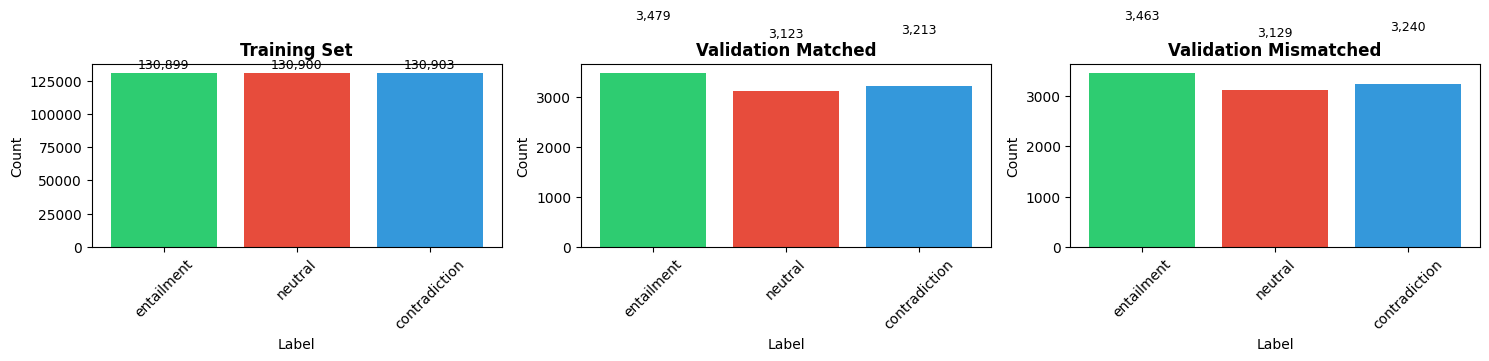


SAMPLE PREMISE-HYPOTHESIS PAIRS

🔍 Sample Examples from Training Set:


LABEL: ENTAILMENT


Filter:   0%|          | 0/392702 [00:00<?, ? examples/s]


Example 1:
  Premise   : you know during the season and i guess at at your level uh you lose them to the next level if if they decide to recall the the parent team the Braves decide to call to recall a guy from triple A then a double A guy goes up to replace him and a single A guy goes up to replace him
  Hypothesis: You lose the things to the following level if the people recall.
  Label     : entailment

Example 2:
  Premise   : One of our number will carry out your instructions minutely.
  Hypothesis: A member of my team will execute your orders with immense precision.
  Label     : entailment

LABEL: NEUTRAL


Filter:   0%|          | 0/392702 [00:00<?, ? examples/s]


Example 1:
  Premise   : Conceptually cream skimming has two basic dimensions - product and geography.
  Hypothesis: Product and geography are what make cream skimming work. 
  Label     : neutral

Example 2:
  Premise   : yeah i tell you what though if you go price some of those tennis shoes i can see why now you know they're getting up in the hundred dollar range
  Hypothesis: The tennis shoes have a range of prices.
  Label     : neutral

LABEL: CONTRADICTION


Filter:   0%|          | 0/392702 [00:00<?, ? examples/s]


Example 1:
  Premise   : Gays and lesbians.
  Hypothesis: Heterosexuals.
  Label     : contradiction

Example 2:
  Premise   : At the end of Rue des Francs-Bourgeois is what many consider to be the city's most handsome residential square, the Place des Vosges, with its stone and red brick facades.
  Hypothesis: Place des Vosges is constructed entirely of gray marble.
  Label     : contradiction


In [8]:

# ============================================================================
# SECTION 2.1: LABEL DISTRIBUTION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("LABEL DISTRIBUTION ANALYSIS")
print("="*80)

def analyze_label_distribution(dataset_split, split_name):
    """Analyze and visualize label distribution"""
    labels = dataset_split['label']
    label_counts = Counter(labels)

    print(f"\n📊 {split_name} Label Distribution:")
    total = len(labels)
    for idx, label_name in enumerate(label_names):
        count = label_counts[idx]
        percentage = (count / total) * 100
        print(f"  {label_name:15s}: {count:7,} ({percentage:.2f}%)")

    return label_counts

# Analyze each split
train_label_counts = analyze_label_distribution(dataset['train'], "Training Set")
val_matched_counts = analyze_label_distribution(dataset['validation_matched'], "Validation Matched")
val_mismatched_counts = analyze_label_distribution(dataset['validation_mismatched'], "Validation Mismatched")

# Visualize label distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
splits = ['train', 'validation_matched', 'validation_mismatched']
titles = ['Training Set', 'Validation Matched', 'Validation Mismatched']

for idx, (split, title) in enumerate(zip(splits, titles)):
    labels = dataset[split]['label']
    label_counts = [Counter(labels)[i] for i in range(len(label_names))]

    axes[idx].bar(label_names, label_counts, color=['#2ecc71', '#e74c3c', '#3498db'])
    axes[idx].set_title(title, fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Count')
    axes[idx].set_xlabel('Label')
    axes[idx].tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for i, v in enumerate(label_counts):
        axes[idx].text(i, v + 1000, f'{v:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('label_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# SECTION 2.2: SAMPLE DATA INSPECTION
# ============================================================================

print("\n" + "="*80)
print("SAMPLE PREMISE-HYPOTHESIS PAIRS")
print("="*80)

# Display sample examples from each label class
samples_per_class = 2

print("\n🔍 Sample Examples from Training Set:\n")
for label_idx, label_name in enumerate(label_names):
    print(f"\n{'='*80}")
    print(f"LABEL: {label_name.upper()}")
    print(f"{'='*80}")

    # Filter examples by label
    label_examples = dataset['train'].filter(lambda x: x['label'] == label_idx)

    for i in range(samples_per_class):
        example = label_examples[i]
        print(f"\nExample {i+1}:")
        print(f"  Premise   : {example['premise']}")
        print(f"  Hypothesis: {example['hypothesis']}")
        print(f"  Label     : {label_name}")



TOKENIZATION AND DATA PREPARATION

📦 Loading tokenizer: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

  Vocabulary size: 30,522
  Model max length: 512
  Padding token: [PAD]
  Separator token: [SEP]
  CLS token: [CLS]

⚙️  Tokenizing datasets...


Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

Map:   0%|          | 0/9796 [00:00<?, ? examples/s]

Map:   0%|          | 0/9847 [00:00<?, ? examples/s]

✅ Tokenization complete!

📊 Tokenized dataset structure:
DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9847
    })
})

SEQUENCE LENGTH ANALYSIS

📏 Training Set Sequence Length Statistics:
  Mean   : 39.69
  Median : 37.00
  Min    : 5
  Max    : 128
  Std Dev: 18.37
  95th percentile: 74.00


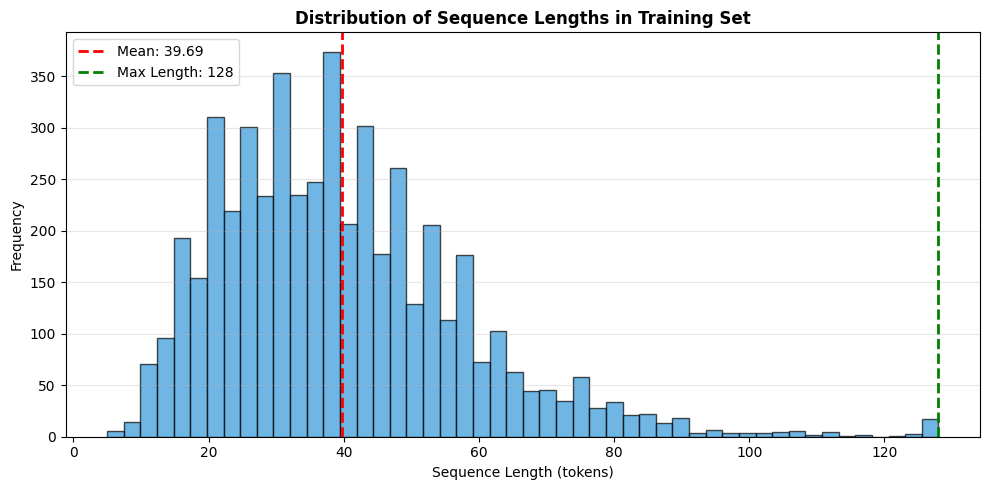

In [9]:

# ============================================================================
# SECTION 3: DATA PREPROCESSING AND TOKENIZATION
# ============================================================================

print("\n" + "="*80)
print("TOKENIZATION AND DATA PREPARATION")
print("="*80)

# Load BERT tokenizer
MODEL_NAME = "bert-base-uncased"
print(f"\n📦 Loading tokenizer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Display tokenizer information
print(f"  Vocabulary size: {tokenizer.vocab_size:,}")
print(f"  Model max length: {tokenizer.model_max_length:,}")
print(f"  Padding token: {tokenizer.pad_token}")
print(f"  Separator token: {tokenizer.sep_token}")
print(f"  CLS token: {tokenizer.cls_token}")

# ============================================================================
# SECTION 3.1: TOKENIZATION FUNCTION
# ============================================================================

def tokenize_function(examples):
    """
    Tokenize premise-hypothesis pairs for BERT sentence-pair classification.

    BERT input format: [CLS] premise [SEP] hypothesis [SEP]
    This allows BERT to learn the relationship between the two sentences.
    """
    return tokenizer(
        examples['premise'],
        examples['hypothesis'],
        truncation=True,           # Truncate if exceeds max_length
        padding='max_length',      # Pad to max_length for batching
        max_length=128,            # Maximum sequence length
        return_tensors=None        # Return lists for dataset mapping
    )

# Apply tokenization to all splits
print("\n⚙️  Tokenizing datasets...")
tokenized_datasets = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['premise', 'hypothesis', 'idx']  # Remove text columns
)

print("✅ Tokenization complete!")
print(f"\n📊 Tokenized dataset structure:")
print(tokenized_datasets)

# ============================================================================
# SECTION 3.2: SEQUENCE LENGTH ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("SEQUENCE LENGTH ANALYSIS")
print("="*80)

# Analyze sequence lengths
def analyze_sequence_lengths(dataset_split, split_name, sample_size=5000):
    """Analyze the distribution of sequence lengths"""
    # Sample for efficiency
    sample_indices = np.random.choice(len(dataset_split), min(sample_size, len(dataset_split)), replace=False)

    lengths = []
    for idx in sample_indices:
        # Count non-padding tokens
        input_ids = dataset_split[int(idx)]['input_ids']
        length = sum(1 for token_id in input_ids if token_id != tokenizer.pad_token_id)
        lengths.append(length)

    lengths = np.array(lengths)

    print(f"\n📏 {split_name} Sequence Length Statistics:")
    print(f"  Mean   : {lengths.mean():.2f}")
    print(f"  Median : {np.median(lengths):.2f}")
    print(f"  Min    : {lengths.min()}")
    print(f"  Max    : {lengths.max()}")
    print(f"  Std Dev: {lengths.std():.2f}")
    print(f"  95th percentile: {np.percentile(lengths, 95):.2f}")

    return lengths

# Analyze training set
train_lengths = analyze_sequence_lengths(tokenized_datasets['train'], "Training Set")

# Visualize sequence length distribution
plt.figure(figsize=(10, 5))
plt.hist(train_lengths, bins=50, color='#3498db', alpha=0.7, edgecolor='black')
plt.axvline(train_lengths.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {train_lengths.mean():.2f}')
plt.axvline(128, color='green', linestyle='--', linewidth=2, label='Max Length: 128')
plt.xlabel('Sequence Length (tokens)')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths in Training Set', fontweight='bold')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('sequence_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


In [10]:

# ============================================================================
# SECTION 4: MODEL INITIALIZATION
# ============================================================================

print("\n" + "="*80)
print("MODEL INITIALIZATION")
print("="*80)

# Load pre-trained BERT model for sequence classification
print(f"\n🤖 Loading model: {MODEL_NAME}")
print(f"   Task: Sequence Classification (3 classes)")

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,          # entailment, contradiction, neutral
    problem_type="single_label_classification"
)

# Move model to device
model = model.to(device)

# Display model information
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Model Architecture:")
print(f"  Total parameters     : {total_params:,}")
print(f"  Trainable parameters : {trainable_params:,}")
print(f"  Model size           : ~{total_params * 4 / (1024**2):.2f} MB")



MODEL INITIALIZATION

🤖 Loading model: bert-base-uncased
   Task: Sequence Classification (3 classes)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



📊 Model Architecture:
  Total parameters     : 109,484,547
  Trainable parameters : 109,484,547
  Model size           : ~417.65 MB


In [15]:

# ============================================================================
# SECTION 5: TRAINING CONFIGURATION
# ============================================================================

print("\n" + "="*80)
print("TRAINING CONFIGURATION")
print("="*80)

# Define compute metrics function
def compute_metrics(eval_pred):
    """Compute accuracy and other metrics for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_score(labels, predictions)

    return {
        'accuracy': accuracy,
    }

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',            # ✅ NEW API
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_ratio=0.1,
    logging_dir='./logs',
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    save_total_limit=2,
    seed=42,
    fp16=torch.cuda.is_available(),
    report_to='none',
)


print("\n⚙️  Training Configuration:")
print(f"  Learning rate        : {training_args.learning_rate}")
print(f"  Train batch size     : {training_args.per_device_train_batch_size}")
print(f"  Eval batch size      : {training_args.per_device_eval_batch_size}")
print(f"  Number of epochs     : {training_args.num_train_epochs}")
print(f"  Weight decay         : {training_args.weight_decay}")
print(f"  Warmup ratio         : {training_args.warmup_ratio}")
print(f"  Mixed precision (FP16): {training_args.fp16}")

# Calculate training steps
steps_per_epoch = len(tokenized_datasets['train']) // training_args.per_device_train_batch_size
total_steps = steps_per_epoch * training_args.num_train_epochs
warmup_steps = int(total_steps * training_args.warmup_ratio)

print(f"\n📈 Training Schedule:")
print(f"  Steps per epoch      : {steps_per_epoch:,}")
print(f"  Total training steps : {total_steps:,}")
print(f"  Warmup steps         : {warmup_steps:,}")



TRAINING CONFIGURATION

⚙️  Training Configuration:
  Learning rate        : 2e-05
  Train batch size     : 32
  Eval batch size      : 64
  Number of epochs     : 3
  Weight decay         : 0.01
  Warmup ratio         : 0.1
  Mixed precision (FP16): True

📈 Training Schedule:
  Steps per epoch      : 12,271
  Total training steps : 36,813
  Warmup steps         : 3,681


In [16]:

# ============================================================================
# SECTION 6: MODEL TRAINING
# ============================================================================

print("\n" + "="*80)
print("STARTING MODEL TRAINING")
print("="*80)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation_matched'],  # Use matched validation
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train the model
print("\n🚀 Training started...\n")
train_result = trainer.train()

# Save the model
print("\n💾 Saving model...")
trainer.save_model('./bert-mnli-finetuned')
tokenizer.save_pretrained('./bert-mnli-finetuned')

print("\n✅ Training complete!")

# Display training results
print("\n" + "="*80)
print("TRAINING RESULTS")
print("="*80)



STARTING MODEL TRAINING

🚀 Training started...



Epoch,Training Loss,Validation Loss,Accuracy
1,0.472900,0.433937,0.833316


Epoch,Training Loss,Validation Loss,Accuracy
1,0.472900,0.433937,0.833316
2,0.335500,0.431803,0.845135
3,0.248100,0.476241,0.849007



💾 Saving model...

✅ Training complete!

TRAINING RESULTS

📊 Final Training Metrics:


ValueError: Cannot specify ',' with 's'.

In [19]:
train_metrics = train_result.metrics
print(f"\n📊 Final Training Metrics:")
print(f"  Training samples     : {train_metrics.get('train_samples', 'N/A')}")
print(f"  Training loss        : {train_metrics.get('train_loss', 'N/A'):.4f}")
print(f"  Training runtime     : {train_metrics.get('train_runtime', 'N/A'):.2f} seconds")
print(f"  Samples per second   : {train_metrics.get('train_samples_per_second', 'N/A'):.2f}")


📊 Final Training Metrics:
  Training samples     : N/A
  Training loss        : 0.3903
  Training runtime     : 7005.28 seconds
  Samples per second   : 168.17


In [20]:

# ============================================================================
# SECTION 7: MODEL EVALUATION
# ============================================================================

print("\n" + "="*80)
print("MODEL EVALUATION")
print("="*80)

# Evaluate on validation matched
print("\n📊 Evaluating on Validation Matched Set...")
eval_matched = trainer.evaluate(tokenized_datasets['validation_matched'])

print("\n✅ Validation Matched Results:")
print(f"  Accuracy : {eval_matched['eval_accuracy']:.4f} ({eval_matched['eval_accuracy']*100:.2f}%)")
print(f"  Loss     : {eval_matched['eval_loss']:.4f}")

# Evaluate on validation mismatched
print("\n📊 Evaluating on Validation Mismatched Set...")
eval_mismatched = trainer.evaluate(tokenized_datasets['validation_mismatched'])

print("\n✅ Validation Mismatched Results:")
print(f"  Accuracy : {eval_mismatched['eval_accuracy']:.4f} ({eval_mismatched['eval_accuracy']*100:.2f}%)")
print(f"  Loss     : {eval_mismatched['eval_loss']:.4f}")

# Compare matched vs mismatched
print("\n📊 Cross-Domain Generalization:")
accuracy_drop = (eval_matched['eval_accuracy'] - eval_mismatched['eval_accuracy']) * 100
print(f"  Matched accuracy    : {eval_matched['eval_accuracy']*100:.2f}%")
print(f"  Mismatched accuracy : {eval_mismatched['eval_accuracy']*100:.2f}%")
print(f"  Accuracy drop       : {accuracy_drop:.2f}%")

if accuracy_drop > 2:
    print("  ⚠️  Significant domain shift observed!")
else:
    print("  ✅ Good cross-domain generalization!")



MODEL EVALUATION

📊 Evaluating on Validation Matched Set...



✅ Validation Matched Results:
  Accuracy : 0.8490 (84.90%)
  Loss     : 0.4762

📊 Evaluating on Validation Mismatched Set...

✅ Validation Mismatched Results:
  Accuracy : 0.8477 (84.77%)
  Loss     : 0.4651

📊 Cross-Domain Generalization:
  Matched accuracy    : 84.90%
  Mismatched accuracy : 84.77%
  Accuracy drop       : 0.13%
  ✅ Good cross-domain generalization!



ERROR ANALYSIS AND CONFUSION MATRIX



📊 Confusion Matrix (Validation Matched):

         Predicted →
Actual ↓   Entail  Neutral  Contra
----------------------------------------
entailment   2,935      401     143
neutral        195    2,591     337
contradiction     128      278   2,807


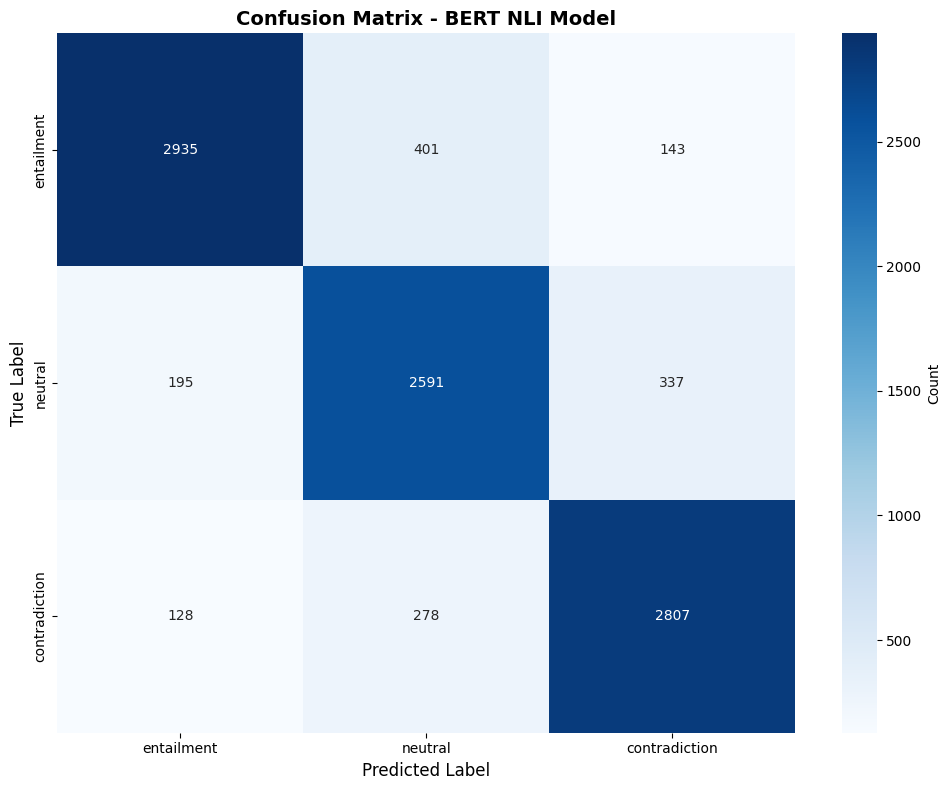


📊 Per-Class Performance:
  entailment     : 0.8436 (84.36%)
  neutral        : 0.8297 (82.97%)
  contradiction  : 0.8736 (87.36%)

📊 Detailed Classification Report:
               precision    recall  f1-score   support

   entailment     0.9009    0.8436    0.8713      3479
      neutral     0.7924    0.8297    0.8106      3123
contradiction     0.8540    0.8736    0.8637      3213

     accuracy                         0.8490      9815
    macro avg     0.8491    0.8490    0.8485      9815
 weighted avg     0.8510    0.8490    0.8495      9815



In [21]:

# ============================================================================
# SECTION 8: DETAILED ERROR ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("ERROR ANALYSIS AND CONFUSION MATRIX")
print("="*80)

# Get predictions on validation matched
predictions = trainer.predict(tokenized_datasets['validation_matched'])
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

print("\n📊 Confusion Matrix (Validation Matched):")
print("\n         Predicted →")
print("Actual ↓   Entail  Neutral  Contra")
print("-" * 40)
for i, label_name in enumerate(label_names):
    print(f"{label_name:10s} {cm[i][0]:7,} {cm[i][1]:8,} {cm[i][2]:7,}")

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - BERT NLI Model', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Per-class accuracy
print("\n📊 Per-Class Performance:")
for i, label_name in enumerate(label_names):
    class_accuracy = cm[i][i] / cm[i].sum()
    print(f"  {label_name:15s}: {class_accuracy:.4f} ({class_accuracy*100:.2f}%)")

# Classification report
print("\n📊 Detailed Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=label_names, digits=4))


In [22]:

# ============================================================================
# SECTION 9: MISCLASSIFICATION ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("MISCLASSIFICATION EXAMPLES")
print("="*80)

# Find misclassified examples
validation_data = dataset['validation_matched']
misclassified_indices = np.where(pred_labels != true_labels)[0]

print(f"\n❌ Total misclassifications: {len(misclassified_indices):,} out of {len(true_labels):,}")
print(f"   Error rate: {(len(misclassified_indices) / len(true_labels)) * 100:.2f}%")

# Analyze common misclassification patterns
misclass_patterns = {}
for idx in misclassified_indices[:1000]:  # Sample for efficiency
    true_label = label_names[true_labels[idx]]
    pred_label = label_names[pred_labels[idx]]
    pattern = f"{true_label} → {pred_label}"
    misclass_patterns[pattern] = misclass_patterns.get(pattern, 0) + 1

print("\n📊 Common Misclassification Patterns:")
for pattern, count in sorted(misclass_patterns.items(), key=lambda x: x[1], reverse=True):
    print(f"  {pattern:30s}: {count:4,} cases")

# Display sample misclassifications
print("\n" + "="*80)
print("SAMPLE MISCLASSIFIED EXAMPLES")
print("="*80)

num_samples = 5
sample_indices = np.random.choice(misclassified_indices, min(num_samples, len(misclassified_indices)), replace=False)

for i, idx in enumerate(sample_indices, 1):
    example = validation_data[int(idx)]
    true_label = label_names[true_labels[idx]]
    pred_label = label_names[pred_labels[idx]]

    print(f"\n{'='*80}")
    print(f"Misclassification Example {i}")
    print(f"{'='*80}")
    print(f"Premise   : {example['premise']}")
    print(f"Hypothesis: {example['hypothesis']}")
    print(f"True Label: {true_label}")
    print(f"Predicted : {pred_label}")

    # Get prediction probabilities
    with torch.no_grad():
        inputs = tokenizer(example['premise'], example['hypothesis'],
                          return_tensors='pt', truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)[0].cpu().numpy()

    print(f"\nPrediction Confidence:")
    for label_idx, label_name in enumerate(label_names):
        print(f"  {label_name:15s}: {probs[label_idx]:.4f} ({probs[label_idx]*100:.2f}%)")



MISCLASSIFICATION EXAMPLES

❌ Total misclassifications: 1,482 out of 9,815
   Error rate: 15.10%

📊 Common Misclassification Patterns:
  entailment → neutral          :  261 cases
  neutral → contradiction       :  236 cases
  contradiction → neutral       :  171 cases
  neutral → entailment          :  134 cases
  entailment → contradiction    :  109 cases
  contradiction → entailment    :   89 cases

SAMPLE MISCLASSIFIED EXAMPLES

Misclassification Example 1
Premise   : Try a selection at the Whisky Heritage Centre (they have over 100 for you to sample), where you can then buy a bottle or two of your personal favorite in the shop or in stores around the city.
Hypothesis: Whisky Heritage Centre was shut down during prohibition.
True Label: neutral
Predicted : contradiction

Prediction Confidence:
  entailment     : 0.0001 (0.01%)
  neutral        : 0.0031 (0.31%)
  contradiction  : 0.9967 (99.67%)

Misclassification Example 2
Premise   : Information  Computer Attacks at Department of

In [23]:

# ============================================================================
# SECTION 10: INFERENCE EXAMPLES
# ============================================================================

print("\n" + "="*80)
print("INFERENCE ON CUSTOM EXAMPLES")
print("="*80)

def predict_nli(premise, hypothesis):
    """Predict NLI relationship between premise and hypothesis"""
    # Tokenize input
    inputs = tokenizer(premise, hypothesis, return_tensors='pt',
                      truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)[0].cpu().numpy()
        pred_label_idx = np.argmax(probs)
        pred_label = label_names[pred_label_idx]

    return pred_label, probs

# Test examples
test_examples = [
    ("A dog is running in the park.", "An animal is outside."),
    ("The cat is sleeping on the couch.", "The cat is playing with yarn."),
    ("All birds can fly.", "Penguins cannot fly."),
    ("The company reported record profits.", "The business is doing well."),
    ("It's raining heavily outside.", "The weather is dry."),
]

print("\n🔍 Testing on Custom Examples:\n")
for i, (premise, hypothesis) in enumerate(test_examples, 1):
    pred_label, probs = predict_nli(premise, hypothesis)

    print(f"{'='*80}")
    print(f"Example {i}")
    print(f"{'='*80}")
    print(f"Premise   : {premise}")
    print(f"Hypothesis: {hypothesis}")
    print(f"Prediction: {pred_label.upper()}")
    print(f"\nConfidence Scores:")
    for label_idx, label_name in enumerate(label_names):
        bar = '█' * int(probs[label_idx] * 50)
        print(f"  {label_name:15s}: {bar} {probs[label_idx]:.4f}")
    print()



INFERENCE ON CUSTOM EXAMPLES

🔍 Testing on Custom Examples:

Example 1
Premise   : A dog is running in the park.
Hypothesis: An animal is outside.
Prediction: ENTAILMENT

Confidence Scores:
  entailment     : ████████████████████████████████████████████████ 0.9780
  neutral        :  0.0061
  contradiction  :  0.0159

Example 2
Premise   : The cat is sleeping on the couch.
Hypothesis: The cat is playing with yarn.
Prediction: CONTRADICTION

Confidence Scores:
  entailment     :  0.0011
  neutral        : █████ 0.1174
  contradiction  : ████████████████████████████████████████████ 0.8815

Example 3
Premise   : All birds can fly.
Hypothesis: Penguins cannot fly.
Prediction: CONTRADICTION

Confidence Scores:
  entailment     :  0.0011
  neutral        : ██ 0.0529
  contradiction  : ███████████████████████████████████████████████ 0.9460

Example 4
Premise   : The company reported record profits.
Hypothesis: The business is doing well.
Prediction: ENTAILMENT

Confidence Scores:
  entailmen


ACADEMIC ANALYSIS AND DISCUSSION


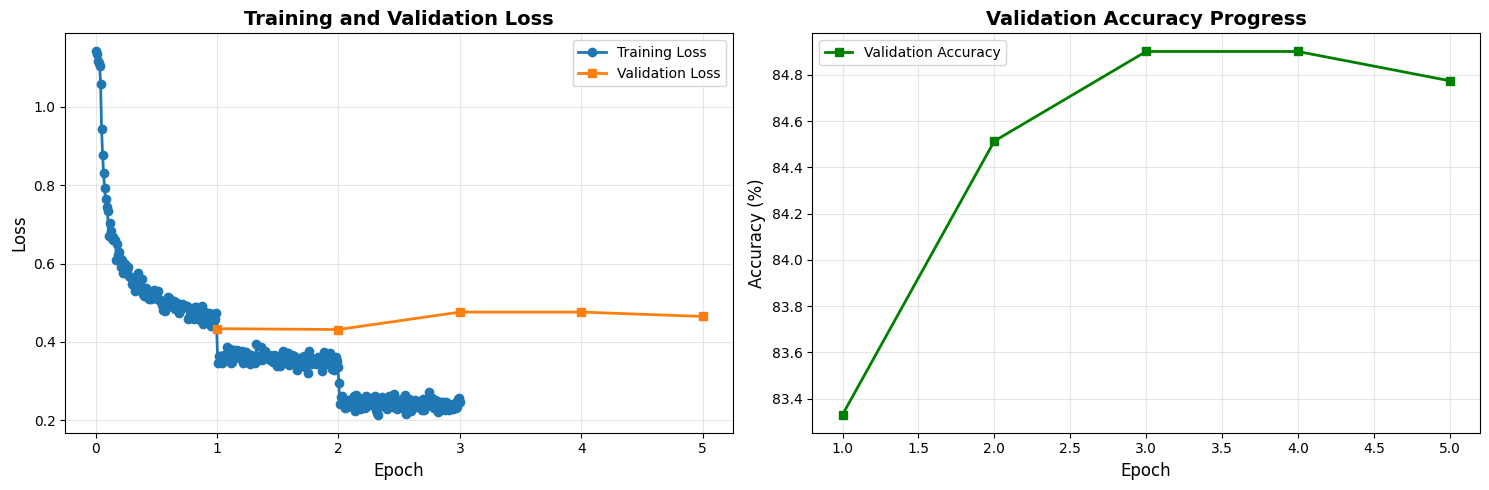

In [24]:

# ============================================================================
# SECTION 11: ACADEMIC ANALYSIS AND DISCUSSION
# ============================================================================

print("\n" + "="*80)
print("ACADEMIC ANALYSIS AND DISCUSSION")
print("="*80)

# Training dynamics visualization
history = trainer.state.log_history

# Extract training and validation metrics
train_losses = [log['loss'] for log in history if 'loss' in log]
eval_accuracies = [log['eval_accuracy'] for log in history if 'eval_accuracy' in log]
eval_losses = [log['eval_loss'] for log in history if 'eval_loss' in log]

# Create epochs array
train_epochs = np.linspace(0, training_args.num_train_epochs, len(train_losses))
eval_epochs = np.arange(1, len(eval_accuracies) + 1)

# Plot training dynamics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(train_epochs, train_losses, label='Training Loss', marker='o', linewidth=2)
ax1.plot(eval_epochs, eval_losses, label='Validation Loss', marker='s', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(eval_epochs, [acc * 100 for acc in eval_accuracies],
         label='Validation Accuracy', marker='s', linewidth=2, color='green')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Validation Accuracy Progress', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_dynamics.png', dpi=300, bbox_inches='tight')
plt.show()
